<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to task 4 of the assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Incy Lin
- <b>Student ID:</b> 30577292  

<div class="alert alert-block alert-danger">

## Table of Contents
    
* [Libraries](#Libraries)
    
* [Task 4.1: Load pretrained model](#t4_1)
    
* [Task 4.2: Create Transformations](#t4_2)
    
* [Task 4.3: Perform occlusion sensitivity analysis](#t4_3)

* [Task 4.4: Discussion Question ](#t4_4)


<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [1]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    
    PATH_DATASETS = '/content/gdrive/MyDrive/...' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [2]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import os
import random
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms

import lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 ## Set to your device

Global seed set to 4179


<div class="alert alert-block alert-info">

# Occlusion Sensitivity Analysis
    
## What you should do in this task!
    
For this task, you will use a pretrained ResNet model from TorchHub. Have a look at the documention [here](https://pytorch.org/hub/pytorch_vision_resnet/).

To feed an image to a resnet model, you need to 
1. Resize the image to 224x224 
2. Normalize the image according to the way training images are normalized for resnet models. This includes subtracting the mean and removing the standard deviation (std) from the color channels (i.e., RGB). The mean and the std are computed from the ImageNet dataset and are provided as mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] for the R, G and B channel respectively.


A good practice to obtain a 224x224 image from an arbitrary one is to first resize the image to 256x256 and then crop the 224x224 part from the center. All of the above can be easily done using transforms from torchvision. Below is an example:

```python
from PIL import Image
from torchvision import transforms
pil_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(pil_image)
```

The PIL [Python Imaging Library](https://pillow.readthedocs.io/en/stable/) is a Python package to read images. In the above code snippet, you first read an image from your HDD (filename is a string showing the file name and its path), and normalize it using the transforms. "img_tensor" will be a torch tensor of size 3x224x224 which you can then use.  

Pay attention to the following:
1. The output of a pretrained resnet models is simply the logit scores. It means the argmax over the output will tell you the class id predicted by the model but you do not have the probability (or confidence) of the prediction. You should use a softmax function to convert the logit scores into a probability vector.

2. The pretrained resnet models can recognize 1,000 classes. The class names are provided to you as a text file and can be attained from this [link](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).

3. You need to put your model into the __eval__ mode (to disable computation of gradients).

4. At the bottom of this [page](https://pytorch.org/hub/pytorch_vision_resnet/), the error of available models is provided. We recommend you to use resnet18 but feel free to try other models.

<div class="alert alert-block alert-info">
    
### Task 4.1: Load pretrained model <a class="anchor" id="t4_1"></a>
    
Use torch hub to download pretrained model weights.

In [3]:
# Load pretrained model using torch hub
resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Change model's mode into eval and transfer to the device you are using
# .cpu() or .cuda()
resnet_model.eval()
resnet_model.to(device)


Using cache found in C:\Users\winky/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<div class="alert alert-block alert-info">
    
### Task 4.2: Create Transformations <a class="anchor" id="t4_2"></a>

We recommend creating two sets of transformations here - one with normalization (so you can pass the image through the model) and one without normalization (so you can plot the original image)

In [4]:
# Transformation with normalization
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transformation without normalization
preprocess_resize_crop = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


<div class="alert alert-block alert-info">
    
### Task 4.3: Perform occlusion sensitivity analysis <a class="anchor" id="t4_3"></a>

Use the cat image from [here](https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg) and perform occlusion sensitivity analysis to understand what parts of the image are important for the predictions. We recommend you to use a patch of size 20x20 with a stride of 5 for occlusion. Your code should be modular enough to accept any patch and stride size.

In [5]:
# You can download ImageNet labels : !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories from the text file given: imagenet_classes.txt
with open(PATH_DATASETS + "/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


# Define patch size & patch stride
patch_size = 20
patch_stride = 5


In [6]:
# img_url : https://upload.wikimedia.org/wikipedia/commons/9/9b/Domestic_cat_cropped.jpg
# Open image using PIL library (commented out below code as it doesn't work)
# img_url = "https://upload.wikimedia.org/wikipedia/commons/9/9b/Domestic_cat_cropped.jpg"
# img_pil = Image.open(requests.get(img_url, stream=True).raw)
#open Domestic_cat_cropped.jpg image
img_pil = Image.open(PATH_DATASETS + "/Domestic_cat_cropped.jpg")

# Now preprocess above image
img_tensor = preprocess(img_pil).to(device)

# Create a mini-batch as expected by the model (here of batchsize 1 - hint: Take a look at 'unsqueeze')
# Apply unsqueeze to the transformed image
img_batch = img_tensor.unsqueeze(0)

In [7]:
# Define eval_img function to predict pretrained model output for above image
# Input parameters to the function: img_batch, model
# Return values: top probability and predicted class (Refer imagenet_classes.txt)
def eval_img(img_batch,model):

    # Set the model to no_grad() first

    with torch.no_grad():
        # Get the model output
        output = model(img_batch)
    

    # Return the highest probability (regardless of class) and the predicted class from the pretrained model
    output = F.softmax(output, dim=1)
    highest_prob, predicted_class = torch.max(output, 1)

    # Show top categories per image
    #images_num = img_batch.shape[0]
    # for i in range(images_num):
    #     print(f"Image {i} : {categories[predicted_class[i]]} with probability {highest_prob[i]}")

    return highest_prob, categories[predicted_class] #  Return values: highest probability and predicted class

In [8]:
# Call eval_img function
# You will use this later
prob0, pred_class_name = eval_img(img_batch,resnet_model)

In [17]:
# Define occlusion_sensitivity function
# Input parameters to the function: patch_size, patch_stride, img_tensor, model
# Return values: img_prob
def occlusion_sensitivity(patch_size, patch_stride, img_tensor, model):
    # Get the Channel size, Height, and Width of the img_tensor
    C, H, W = img_tensor.shape
    
    # Calculate the size of your patch. 
    # This can be done by using your patch_size and patch_stride
    # Sound familiar? 
    # Hint: look at the calculation for convolution dimensions
    patch_size = np.floor(1+(H-patch_size)/patch_stride).astype(int)
    # Set the patch as zeroes
    patch = torch.zeros((patch_size,patch_size)).to(device)

    # Apply the patch across the entire image
    # You can go by height first, then by rows
    # When overlaying your patch across the image, ensure that you .clone() the tensor first
    # You can also call the eval_img() function you have created. 
    # It might also be faster to compute if the code within the function is pasted here instead
    # This is because Python uses the memory address when you do "temp_tensor = original_tensor"

    #make an empty image the same size as the original image
    img_prob = torch.zeros((1,H,W))
    count = 0
    #print("patch_size: ", patch_size)
    for i in range(0, H-patch_size, patch_stride):
        for j in range(0, W-patch_size, patch_stride):
            temp_tensor = img_tensor.clone()
            temp_tensor[:,i:i+patch_size,j:j+patch_size] = 0 #zero out elements inside the patch
            #measure confidence of resnet
            #resize temp_tensor to 4d tensor
            temp_tensor = temp_tensor.unsqueeze(0)
            #print("temp_tensor shape: ", temp_tensor.shape)
            probability = eval_img(temp_tensor,model)[0]
            #assign all values in image_prob within the current patch to be probability
            #print("assigning pixels from ", i, " to ", i+patch_size, " and ", j, " to ", j+patch_size, " to be ", probability)
            img_prob[:,i:i+patch_size,j:j+patch_size] = probability
            count+=1
    #print("count: ", count)
    return img_prob  # return final image probabilities across the entire image dimension

# Define plot_occlusion_sensitivity function
# Input parameters to the function: img_pil, img_prob
def plot_occlusion_sensitivity(img_pil, img_prob):
    
    ## img_pil is the PIL image
    ## img_prob is the extracted probabilities for each patch
    preprocess_img_pil = preprocess_resize_crop(img_pil)
    
    #normalise img_prob between maximum prob and minimum prob
    img_prob = 255*((img_prob - img_prob.min())/(img_prob.max() - img_prob.min()))
    # print("im_prob shape: ", img_prob.shape)

    fig, axes = plt.subplots(1,2, figsize=(10,10))
    axes[0].imshow(preprocess_img_pil.numpy().transpose(1,2,0))
    #print("original shape", preprocess_img_pil.numpy().transpose(1,2,0).shape)
    axes[0].set_title('Original Image')
    axes[1].imshow(img_prob.numpy().transpose(1,2,0),cmap='hot')
    #print("img_prob shape", img_prob.numpy().transpose(1,2,0).shape)
    axes[1].set_title('Occlusion Sensitivity')
    plt.show()

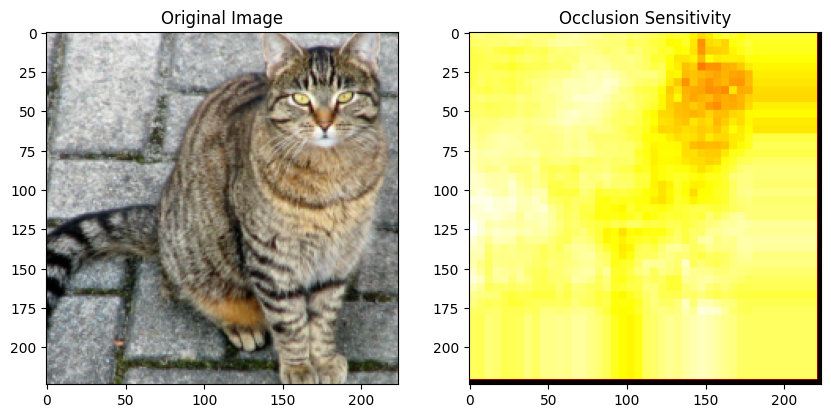

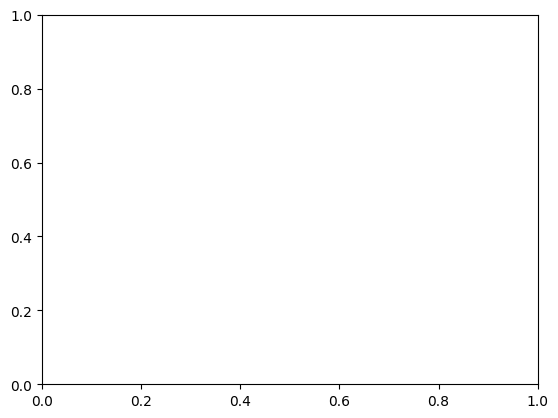

In [19]:
# Call occlusion_sensitivity method and get image probabilities 
# For the cat image
img_prob = occlusion_sensitivity(patch_size, patch_stride, img_tensor, resnet_model)

# Call plot_occlusion_sensitivity and visualize the output
# For the cat image
plot_occlusion_sensitivity(img_pil, img_prob)

In [11]:
# Display the predicted class for the input image from eval_image
print(pred_class_name)

tabby


Now use an image of your choice that the model cannot recognize correctly. For example, this is [Wendy](https://i.cbc.ca/1.5352059.1573161914!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/wandi.jpg) but ResNet18 incorrectly classifies it  as a Pembroke (a breed of dog). Perform occlusion senstivity to understand what parts of image are important for its incorrect prediction. Do you give the model some credit for its mistake?

Read more about Wendy [here](https://www.khou.com/article/news/nation-world/eterinarians-in-australia-believe-endangered-dingo-pup-was-dropped-by-an-eagle/507-2658a23e-1144-433d-a215-77474bfd9a71). 

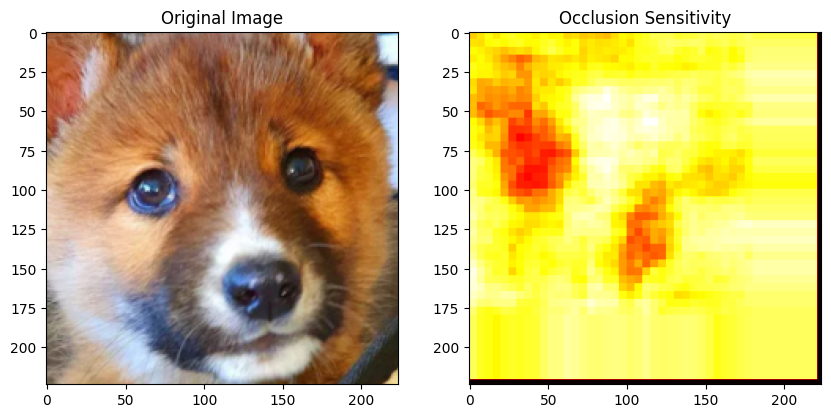

Pembroke


In [14]:
# img_url : https://i.cbc.ca/1.5352059.1573161914!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/wandi.jpg
# Open image using PIL library
# img_url = "https://i.cbc.ca/1.5352059.1573161914!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/wandi.jpg"
# img_pil = Image.open(requests.get(img_url, stream=True).raw)
img_pil1 = Image.open(PATH_DATASETS + "/wandi.jpg") #open locally 
# Now preprocess above image
img_tensor1 = preprocess(img_pil1).to(device)

# Create a mini-batch as expected by the model
img_batch1 = img_tensor1.unsqueeze(0)
prob1, pred_class_name2 = eval_img(img_batch1,resnet_model)
# Evaluate and print the image's class. Call occlusion_sensitivity and plot_occlusion_sensitivity
img_prob1 = occlusion_sensitivity(patch_size, patch_stride, img_tensor1, resnet_model)
plot_occlusion_sensitivity(img_pil1, img_prob1)
print(pred_class_name2)

<div class="alert alert-block alert-success">
    
### Task 4.4: Discussion Question <a class="anchor" id="t4_4"></a>
    
### Question:

1. What is the reason for upsizing the image before applying a center crop?

2. With occlusion sensitivity, you may have noticed we are not interested in the actual image's predicted class probability. Can you explain why?


3. What are similar features that have been identified between the two images with the occlusion sensitivity analysis? Why have these features been identified?


4. Why has Wendy been classified as a Pembroke in this case?
    
### Answer

1. Upsizing the image mitigates the amount of data lost when applying center crop by adding more pixels, allowing you to retain a larger proportion of the original image's content after cropping. It can also help preserve the original aspect ratio.

2. Because we want to know which sections of the image are most vital when classifying the image. If we just use the actual image's predicted class probability, we have no idea what part of the actual image contributed the post in classifying it. However, if we remove sections of the original image and attempt to classify, we can see the impact of removing that particular section by analysing it's predicted class probability and thus gauge how important that section is for classification. 

3. The areas with the lowest probabilities (darkest colours) are around the face for both images. As cat and dog bodies can be pretty similar across breeds, the face is an important deciding factor for classification.

4. Because Wendy is still a puppy its face looks quite similar to a pembroke rather than a dingo. Since its body is not shown in the picture, it's quite hard to differentiate between Wendy and a pembroke.